In [ ]:
%whos

In [1]:
import json
import os
from IPython.display import Javascript

os.environ['R_HOME'] = 'C:/Users/erneilso/Documents/R/R-4.1.1/'
%load_ext rpy2.ipython

inputFile = r'C:\Users\erneilso\OneDrive - NRCan RNCan\Collaborations\RC Steering Committee\MonitoringDecisionTool\Inputs\CYOA.json'
f = open(inputFile)
iData = json.load(f)["DT_Branches"]; f.close()

# INPUT DATA
%run -i ./DST_Functions.py

C:\Users\erneilso\AppData\Local\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(



Do you want to 
 (1) Answer a specific question? 
 (2) Collect monitoring data 
 (3) Input a set of layers 
 (B) Back
3

 (1) Enter spatial data 
 (B) Back
1

The study area has (417996.4415538451, 795945.195356781, 1126884.4543278955, 1581144.825542611). 
It has 76 rows and 91 columns.

resampling raster to study area

converting shapefile to raster
converting raster to distance

converting shapefile to raster
converting raster to distance

Finished inputing Use vars: ['DEM', 'WaterProx', 'CEC']


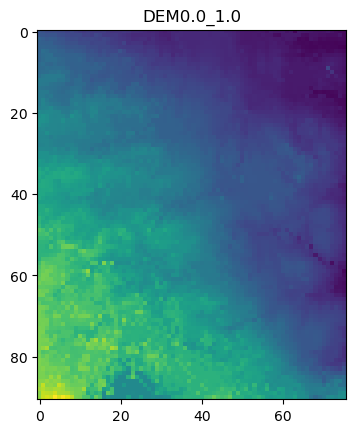

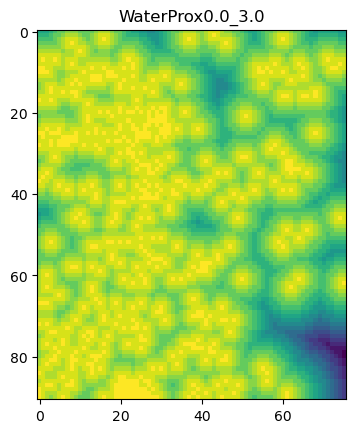

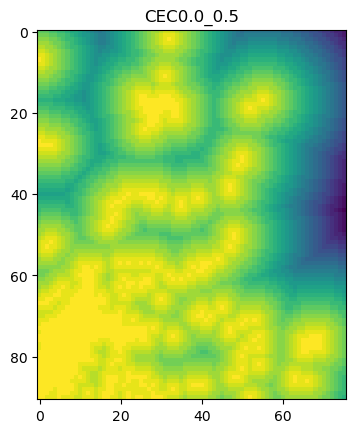

Finished inputing Det vars: []

 (1) Move to next section.1
exit tool


<IPython.core.display.Javascript object>

In [2]:
### INPUT DATA
%run -i ./DST_Functions.py
readQuestion(iData,"0") 

## simulate resposne
Javascript("Jupyter.notebook.execute_cells([3])")


 (1) Simulate response 
1
Used the inputted rasters to simulate the spatial probability of use across study area


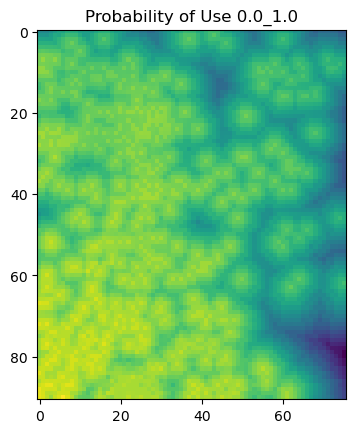


Converting use into occupancy. What is true the true proportion of the area that is occupied (number between 0 and 1)?0.3

The threshold for predicting occupancy given the probability of use 0.79. There are 2075 occupied pixels (51875.0 km occupied area). This leads to an instantaneous probability of detection in any cell for one, randomly moving, individual of 0.0005


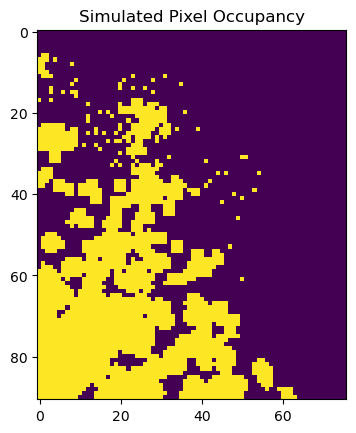


Simulate a population within the occupied cells using a population density. Is the species (1) common , (2) rare, (3) very-rare?2

With a density of 0.01 individuals per pixel across all occupied pixels, the total population is 518.75. This gives an instantaneous probability of use of any occupied cell, of any randomly moving individual, of 0.25

Given the spatial variation in probability of use for the population and variation in detection at each site, the mean instantaneous probability of detection across occupied cells, for any randomly moveing individual, is 0.0634


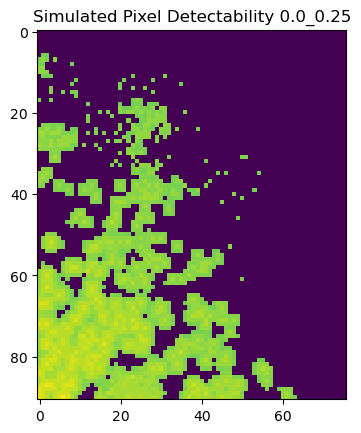


 (1) Move to next section.1
exit tool


<IPython.core.display.Javascript object>

In [3]:
# SIMULATE RESPONSE
readQuestion(iData,"8") 

## simulate data
Javascript("Jupyter.notebook.execute_cells([4])")

In [10]:

##### SIMULATE DATA
readQuestion(iData,"9") 

## run the R initialization cell should be cell 3
Javascript("Jupyter.notebook.execute_cells([5])")


 (1) Assess power given an array of cameras 
1
Enter the number of site scenarios.6
Enter the max number of cameras.100
Enter the min number of cameras.10
Enter the number of duration scenarios.6
Enter the max duration of deployments (weeks).50
Enter the min duration of deployments (weeks).10

 (1) Move to next section.1
exit tool


<IPython.core.display.Javascript object>

In [11]:
# import pandas as pd
# dh = pd.DataFrame(DetectionHistory)
# dh.to_csv(outputPathPrefix + '/dh.csv', index=False)  

%R -i outputPathPrefix
%R -i trueOcc
%R -i popPX
%R -i N
%R -i meanDetection

## run the R initialization cell should be cell 3
Javascript("Jupyter.notebook.execute_cells([6])")

<IPython.core.display.Javascript object>

In [12]:
%%R

library(unmarked)

OccOutTab = data.frame(CamN = NA, IntervalsN = NA, Response = NA, Estimate = NA, SE = NA, Bias = NA)
scenCount = 0

dhScenDirs = list.dirs(paste0(outputPathPrefix,'/DetectionHistories'),recursive = FALSE)  
#print(dhScenDirs)

for (dir in dhScenDirs){    

    scenI = unlist(strsplit(dir,"/"))
    scen = scenI[length(scenI)]
    scen = unlist(strsplit(scen,"_"))
    CameraNumber = scen[1]
    VisitsNumber = scen[2]
#     print(CameraNumber)
#     print(VisitsNumber)

    dhScens = list.files(dir,pattern="\\.csv$")
    
    for (scen in dhScens){
        
        dh = read.csv(paste0(dir,"/",scen),header=T)

        ## fit model to scenario data
        umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
        fm <- occu(~1 ~1, umf) # fit a model

        ## model outputs
        psiTab = predict(fm, type="state",newdata=data.frame(1))
        psi = psiTab$Predicted
        psiSE = psiTab$SE
        psiBias = psi - trueOcc
        pTab = predict(fm, type="det",newdata=data.frame(1))
        p = pTab$Predicted
        pSE = pTab$SE
        pBias = p - meanDetection
        
        ## occupancy info
        scenCount = scenCount + 1
        OccOutTab[scenCount,"CamN"] = CameraNumber
        OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
        OccOutTab[scenCount,"Response"] = "psi"
        OccOutTab[scenCount,"Estimate"] = psi
        OccOutTab[scenCount,"SE"] = psiSE
        OccOutTab[scenCount,"Bias"] = psiBias
        
        ## detection info
        scenCount = scenCount + 1
        OccOutTab[scenCount,"CamN"] = CameraNumber
        OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
        OccOutTab[scenCount,"Response"] = "p"
        OccOutTab[scenCount,"Estimate"] = p
        OccOutTab[scenCount,"SE"] = pSE
        OccOutTab[scenCount,"Bias"] = pBias

        }
    }

    ##print(OccOutTab)
print("Fit occupancy models to all deteciton histories.")


[1] "Fit occupancy models to all deteciton histories."


In [7]:
%%R

#print(head(OccOutTab))
require(tidyverse)

SumTab = OccOutTab %>%
    group_by(CamN, IntervalsN, Response) %>%
    summarise(
        N = length(Estimate),
        meanEstimate = mean(Estimate),
        sdEstimate = sd(Estimate),
        seEstimate   = sdEstimate / sqrt(N),
        
        meanSE = mean(SE),
        sdSE = sd(SE),
        seSE   = sdSE / sqrt(N),
        
        meanBias = mean(Bias),
        sdBias = sd(Bias),
        seBias   = sdBias / sqrt(N)) %>%
    mutate(CamN = as.integer(CamN),
           Durations = as.integer(IntervalsN))

print(SumTab)
    

-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.1     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
`summarise()` has grouped output by 'CamN', 'IntervalsN'. You can override using the `.groups` argument.
# A tibble: 32 x 14
# Groups:   CamN, IntervalsN [16]
    CamN IntervalsN Response     N meanEstimate sdEstimate seEstimate meanSE
   <int> <chr>      <chr>    <int>        <dbl>      <dbl>      <dbl>  <dbl>
 1    10 17         p           10        0.175   0.0745    0.0236    0.0675
 2    

Loading required package: tidyverse
In addition: Warning messages:
1: package 'tidyverse' was built under R version 4.1.3 
2: package 'ggplot2' was built under R version 4.1.3 
3: package 'tibble' was built under R version 4.1.3 
4: package 'tidyr' was built under R version 4.1.3 
5: package 'readr' was built under R version 4.1.3 
6: package 'purrr' was built under R version 4.1.3 
7: package 'dplyr' was built under R version 4.1.3 
8: package 'stringr' was built under R version 4.1.3 
9: package 'forcats' was built under R version 4.1.3 
10: package 'lubridate' was built under R version 4.1.3 


# A tibble: 32 x 14
# Groups:   CamN, IntervalsN [16]
    CamN IntervalsN Response     N meanEstimate sdEstimate seEstimate meanSE
   <int> <chr>      <chr>    <int>        <dbl>      <dbl>      <dbl>  <dbl>
 1    10 17         p           10        0.175   0.0745    0.0236    0.0675
 2    10 17         psi         10        0.224   0.0390    0.0123    0.150 
 3    10 29         p           10        0.217   0.0664    0.0210    0.0536
 4    10 29         psi         10        0.201   0.00168   0.000530  0.127 
 5    10 41         p           10        0.201   0.0472    0.0149    0.0439
 6    10 41         psi         10        0.200   0.000183  0.0000579 0.127 
 7    10 5          p           10        0.152   0.193     0.0611    0.0953
 8    10 5          psi         10        0.677   0.415     0.131     0.243 
 9    22 17         p           10        0.187   0.0722    0.0228    0.0497
10    22 17         psi         10        0.181   0.0238    0.00754   0.0854
# i 22 more rows
# i 6

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


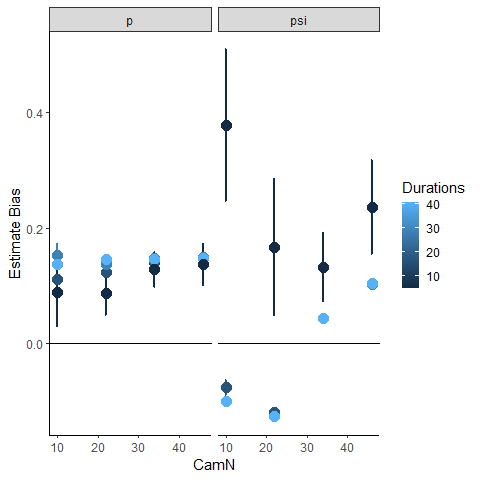

In [8]:
%%R

library(ggplot2)

print(SumTab)

occPlot = ggplot(SumTab, aes(x=CamN, y=meanBias, colour=Durations,
                   ymin=meanBias-seBias, ymax=meanBias + seBias)) + 
  geom_errorbar(size=1,width=0.1) +
  #geom_line(size=1,aes(group=Durations))+
  geom_point(size=5)+
  #geom_line(aes(x=CamN,y=meanBias,group=Durations))+
  theme_bw(base_size=15)+ facet_grid(.~Response)+
  ylab("Estimate Bias")+
  theme(panel.border = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  geom_abline(size=0.5,intercept = 0, slope=0)

library(grid)
grid::grid.newpage()
vp <- viewport(width = 3, height = 2)
pushViewport(vp)
grid.draw(occPlot)


In [ ]:
#### EVERYTHING FROM HERE DOWN IS SCRAP


In [ ]:
%%R

#%%R -i dh

## OCCUPANCY MODEL
dh = read.csv(paste0(outputPathPrefix,"/","40_3518.750.25_dh.csv"),header=F)
#print(dh)

library(unmarked)
umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
#umf # look at data
#summary(umf) # summarize


fm <- occu(~1 ~1, umf) # fit a model
summary(fm)
p<-backTransform(fm, type = "det")
print(p)
print('')
psi1<-backTransform(fm, type = "state")
print(psi1)
psi = predict(fm, type="state",newdata=data.frame(1))
print(psi$Predicted)
print(psi$SE)
#print(str(psi))
#print(psi@ estimate)



# print(predict(fm, type="state",newdata=data.frame(1)))
# psi = print(sum(bup(ranef(fm), stat="mode")) / as.numeric(camN)) # Sum of posterior modes

# print(paste0("The model estimated proportion of sites occupied is:", psi))
# print(paste0("The true proportion of sites is: ",trueOcc))





In [ ]:
%%R
dh = read.csv('C:/Users/erneilso/OneDrive - NRCan RNCan/Collaborations/RC Steering Committee/MonitoringDecisionTool/Outputs/dh.csv')
print(dh)

library(unmarked)
umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
umf # look at data
summary(umf) # summarize
fm <- occu(~1 ~1, umf) # fit a model

summary(fm)


In [ ]:
%%R -i trueOcc
print(346/1400)
data.frame(trueOcc)

In [ ]:
## https://stackoverflow.com/questions/68055242/how-do-i-solve-the-parsing-error-when-using-rpy2

# get_ipython().run_cell_magic(
# "R",
# "-i dh",
# '''

# library(unmarked)
# umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
# umf # look at data
# summary(umf) # summarize
# #fm <- occu(~1 ~1, umf) # fit a model

# '''
# )



%%R
# dh = read.csv('C:/Users/erneilso/OneDrive - NRCan RNCan/Collaborations/RC Steering Committee/MonitoringDecisionTool/Outputs/dh.csv')
# print(nrow(dh))

#print(.libPaths())
install.packages("unmarked")
#install.packages("pbapply")


####
##https://www.datacamp.com/blog/jupyter-and-r-markdown-notebooks-with-r


#print(dh)
# foo = 1000

# print(foo)

# print(DetectionHistory)

In [ ]:
%%R

range01 <- function(x){(x-min(x))/(max(x)-min(x))}

# population
pxN = 50000
cell_size = 5000
cell_sizeKM = cell_size/1000000
dens = 0.1 ## /km 
N = dens * cell_sizeKM * pxN
print(N)

# activity
px = range01(rexp(pxN))
#hist(px)
perPX = 1/pxN  # the perpixel instatntaneous probabilyt of deteciotn is 1 over the nubmer of cells
popPX = N * perPX
print(popPX)